## Important
This notebook consists of the SVM model which I have tried to train on the same my_full_data.csv file, but only difference is I did some extra pre-processing of my own by one hot coding some of the data which was not required to do so, but I thought it made sense. Obviously this notebook does not conist of all the results due to the vast number of parameters that I ended up with, which is 89 and a result the computation time for the GridSearchCV was extremely long and tiresome, where at first I have considered __scoring = accuracy__ and then __scoring = roc_auc__ for GridSearchCV. The simmilar technique was used in the final model as well. Hence, this notebook was not completed but I am still providing it as a comparison to the final cut of the models I have trained which is __SVM_MODEL.ipynb__.

In [1]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [2]:
data=pd.read_csv('my_full_data.csv')

In [3]:
data=data.drop('id',axis=1)

In [4]:
data['application_type']=data['application_type'].replace({'Individual':0, 'Joint App':1})

In [5]:
data['initial_list_status']=data['initial_list_status'].replace({'w':0,'f':1})
data

,Unnamed: 0,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,purpose,addr_state,dti,open_acc,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,application_type,tax_liens
0,0,2500.0,0,17.27,89.47,3,1,1,50000.0,2,...,9,9,17.60,7.0,22.0,1,669.0,665.0,0,0.0
1,1,7200.0,0,17.27,257.67,3,9,4,20000.0,2,...,2,18,13.21,8.0,17.0,1,549.0,545.0,0,0.0
2,2,16000.0,0,10.78,522.16,1,5,5,63000.0,0,...,2,33,35.19,12.0,22.0,1,594.0,590.0,0,0.0
3,3,16000.0,0,5.32,481.84,0,8,1,96000.0,0,...,2,22,14.45,23.0,38.0,1,744.0,740.0,0,0.0
4,4,13000.0,1,16.59,320.23,3,10,5,40000.0,2,...,2,11,16.74,6.0,17.0,1,569.0,565.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26113,26113,12000.0,0,13.99,410.08,2,0,5,47000.0,1,...,1,25,31.79,13.0,28.0,0,754.0,750.0,0,0.0
26114,26114,25000.0,1,25.69,743.94,5,6,1,70000.0,2,...,9,5,15.10,9.0,19.0,0,499.0,0.0,0,0.0
26115,26115,16000.0,0,12.79,537.49,2,1,4,48000.0,0,...,2,4,33.60,11.0,17.0,0,699.0,695.0,0,0.0
26116,26116,35000.0,1,15.59,843.53,2,1,1,180000.0,2,...,2,9,13.09,17.0,31.0,0,714.0,710.0,0,0.0


In [6]:
data['addr_state'].unique()

array([ 9, 18, 33, 22, 11, 34, 42, 23, 24, 14, 28,  4,  6, 44,  1, 19, 39,
       10, 21, 13,  2, 26, 41, 29,  5, 46, 48, 37,  8, 38, 47, 36, 30, 17,
       43, 32,  3, 25, 15,  7, 16, 31, 35, 27, 20, 45, 49,  0, 40, 12],
      dtype=int64)

In [7]:
def onehot_encode(data,column):
    data=data.copy()
    dummies=pd.get_dummies(data[column],prefix=column,dtype=int)
    data=pd.concat([data,dummies],axis=1)
    data=data.drop(column,axis=1)
    return data

In [8]:
data =onehot_encode(data,'addr_state')

In [9]:
data['purpose'].unique()

array([ 9,  2,  4,  1,  7,  0,  6, 12,  8, 11,  5, 10, 13,  3],
      dtype=int64)

In [10]:
data=onehot_encode(data,'purpose')

In [11]:
data['verification_status']=data['verification_status'].replace({'Not Verified':0, 'Source Verified':1, 'Verified':2})

In [12]:
data['home_ownership']=data['home_ownership'].replace({'MORTGAGE':0, 'RENT':1, 'OWN':2, 'ANY':3, 'NONE':4, 'OTHER':4})

In [13]:
data['emp_length']=data['emp_length'].replace({'10+ years':10, '3 years':3, '6 years':6, '1 year':1, '7 years':7, '8 years':8,
       '5 years':5, '2 years':2, '9 years':9, '< 1 year':0, '4 years':4})

In [14]:
data['term']=data['term'].replace({' 36 months':0, ' 60 months':1})

In [15]:
for column in data.columns:
    if data[column].dtype=='bool':
        data[column]=data[column].astype(int)

In [16]:
[column for column in data.columns if data[column].dtype=='object']

[]

In [17]:
data=onehot_encode(data,'grade')
data

,Unnamed: 0,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,purpose_11,purpose_12,purpose_13,grade_0,grade_1,grade_2,grade_3,grade_4,grade_5,grade_6
0,0,2500.0,0,17.27,89.47,1,1,50000.0,2,1,...,0,0,0,0,0,0,1,0,0,0
1,1,7200.0,0,17.27,257.67,9,4,20000.0,2,0,...,0,0,0,0,0,0,1,0,0,0
2,2,16000.0,0,10.78,522.16,5,5,63000.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,16000.0,0,5.32,481.84,8,1,96000.0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,4,13000.0,1,16.59,320.23,10,5,40000.0,2,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26113,26113,12000.0,0,13.99,410.08,0,5,47000.0,1,1,...,0,0,0,0,0,1,0,0,0,0
26114,26114,25000.0,1,25.69,743.94,6,1,70000.0,2,0,...,0,0,0,0,0,0,0,0,1,0
26115,26115,16000.0,0,12.79,537.49,1,4,48000.0,0,1,...,0,0,0,0,0,1,0,0,0,0
26116,26116,35000.0,1,15.59,843.53,1,1,180000.0,2,1,...,0,0,0,0,0,1,0,0,0,0


In [18]:
from sklearn.model_selection import train_test_split
y=data['loan_status']
x=data.drop('loan_status',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,random_state=123,shuffle=True)

In [19]:
x_train.shape

(20894, 88)

In [20]:
x_test.shape

(5224, 88)

In [21]:
scaler=StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [22]:
svm_rbf = SVC(kernel='rbf',probability=True,random_state=42,C=1,class_weight='balanced')

In [23]:
svm_rbf = svm_rbf.fit(x_train,y_train)

In [24]:
y_pred = svm_rbf.predict(x_test)
y_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 86.93%
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.83      0.73      1099
           1       0.95      0.88      0.91      4125

    accuracy                           0.87      5224
   macro avg       0.80      0.85      0.82      5224
weighted avg       0.89      0.87      0.87      5224



In [26]:
y_pred1 = svm_rbf.predict_proba(x_test)[:, 1]
y_pred1

array([0.99687358, 0.93847232, 0.97210449, ..., 0.86652852, 0.89463605,
       0.08436686])

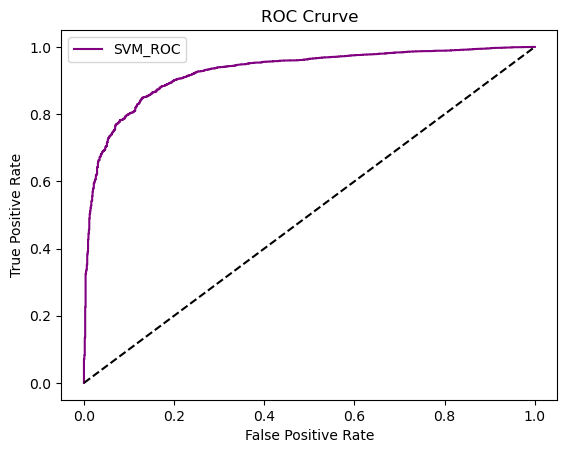

In [27]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred1)
plt.plot(fpr, tpr, color='purple', label='SVM_ROC')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Crurve')
plt.legend()
plt.show()

In [28]:
param_grid = {
    'svc__C': [0.1,1,5,10,15,20,25,40,35,40,45,50,55,60,65,70,75,80,85,90,95,100],        
    'svc__gamma': [1, 0.1, 0.01, 0.001],
    'svc__kernel': ['rbf']     
}

pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

In [31]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy',n_jobs=-1)

In [ ]:
grid_search = grid_search.fit(x_train, y_train)

In [30]:
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

Best parameters:  {'svc__C': 5, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.89


In [31]:
svm_rbf_best_param = SVC(kernel='rbf',gamma=0.001,C=5,probability=True)
svm_rbf_best_param = svm_rbf_best_param.fit(x_train,y_train)

In [32]:
y_pred2 = svm_rbf_best_param.predict(x_test)
y_pred2

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [33]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 89.51%
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      1099
           1       0.92      0.95      0.93      4125

    accuracy                           0.90      5224
   macro avg       0.85      0.83      0.84      5224
weighted avg       0.89      0.90      0.89      5224



In [34]:
y_pred3 = svm_rbf_best_param.predict_proba(x_test)[:, 1]
y_pred3

array([0.99541227, 0.96525021, 0.97387853, ..., 0.88741415, 0.94277145,
       0.01529227])

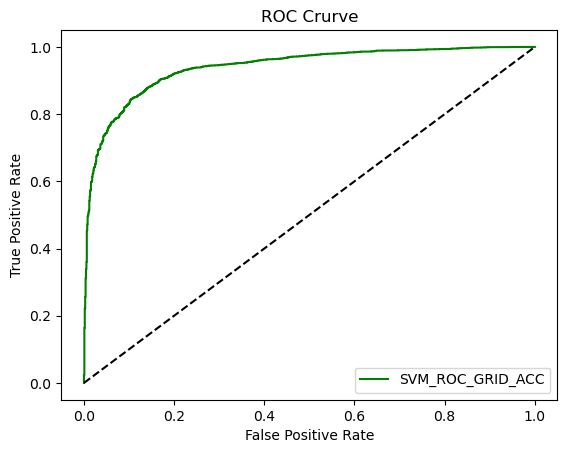

In [35]:
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred3)
plt.plot(fpr1, tpr1, color='green', label='SVM_ROC_GRID_ACC')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Crurve')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred3)
plt.plot(fpr, tpr, color='purple', label='SVM_ROC_GRID_AUC')
plt.plot(fpr1, tpr1, color='green', label='SVM_ROC_GRID_AUC')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Crurve')
plt.legend()
plt.show()

In [26]:
grid_search1 = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')

In [27]:
grid_search1 = grid_search1.fit(x_train, y_train)

In [28]:
print("Best parameters: ", grid_search1.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search1.best_score_))

Best parameters:  {'svc__C': 5, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.94


In [ ]:
y_pred4 = grid_search1.predict(x_test)
y_pred4

In [ ]:
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred4)

In [32]:
y_pred5 = grid_search1.predict_proba(x_test)[:, 1]
y_pred5

array([0.99540339, 0.96521827, 0.97385069, ..., 0.88737946, 0.94273364,
       0.01533284])

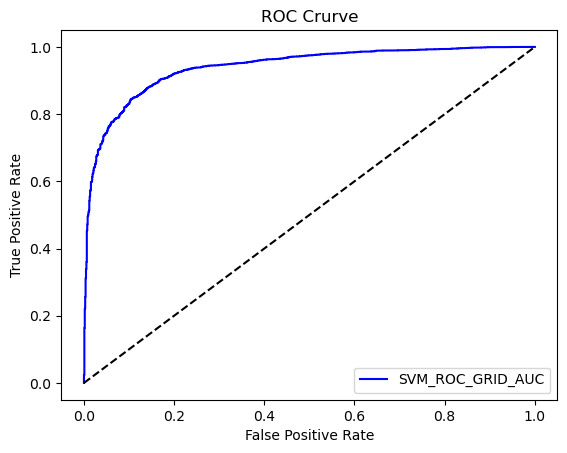

In [37]:
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred5)
plt.plot(fpr2, tpr2, color='blue', label='SVM_ROC_GRID_AUC')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Crurve')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred3)
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred5)
plt.plot(fpr, tpr, color='purple', label='SVM_ROC_GRID_AUC')
plt.plot(fpr1, tpr1, color='green', label='SVM_ROC_GRID_AUC')
plt.plot(fpr2, tpr2, color='blue', label='SVM_ROC_GRID_AUC')
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Crurve')
plt.legend()
plt.show()